<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Data Modeling
</div>

## Import thư viện cần thiết

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, MinMaxScaler, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pickle

<h3> Chúng ta sẽ nhìn lại tập dữ liệu sau quá trình tiền xử lý và khai thác </h3>

In [9]:
cleaned_df = pd.read_csv('../data/processed_data.csv')

In [10]:
cleaned_df.head(10)

,Title,Genre,withDLC,isMature,Developer,Publisher,Languages,PositiveReviews,TotalReviews,NegativeReviews,OriginalPrice,DiscountPercent,DiscountedPrice,ReleaseYear,ReleaseMonth,ReleaseDay,Rating
0,HumanitZ,"Action, Adventure, RPG, Early Access",0.0,0.0,Yodubzz Studios,Freedom Games,"English, French, German, Spanish - Spain, Japa...",1581.0,2081.0,500.0,260000.0,0.20,208000.0,2023,9,18,0.733696
1,Ratopia,"Adventure, Casual, Indie, Simulation, Strategy...",1.0,0.0,Cassel Games,Cassel Games,"English, Korean, Japanese, Simplified Chinese,...",1602.0,1807.0,205.0,260000.0,0.10,234000.0,2023,11,5,0.846123
2,Void Crew,"Action, Adventure, Early Access",0.0,0.0,Hutlihut Games,Focus Entertainment,"English, French, German, Spanish - Spain, Poli...",2071.0,2280.0,209.0,286000.0,0.20,228800.0,2023,9,7,0.868512
3,Bread & Fred,"Action, Adventure, Casual, Indie",1.0,0.0,SandCastles Studio,Apogee Entertainment,"English, Spanish - Spain, Catalan, French, Ita...",2332.0,2644.0,312.0,205000.0,0.25,153750.0,2023,5,23,0.846368
4,Mind Over Magic,"Simulation, Early Access",0.0,0.0,Sparkypants,Klei Publishing,"English, Simplified Chinese",583.0,632.0,49.0,220000.0,0.10,198000.0,2023,12,14,0.861866
5,Cobalt Core,"Indie, Strategy",1.0,0.0,Rocket Rat Games,Brace Yourself Games,"English, French, German, Spanish - Spain, Japa...",1333.0,1367.0,34.0,260000.0,0.20,208000.0,2023,11,8,0.921083
6,Cuisineer,"Action, Adventure, Casual, Indie, RPG, Simulation",1.0,0.0,BattleBrew Productions,Marvelous Europe,"English, French, German, Spanish - Spain, Japa...",837.0,1069.0,232.0,321000.0,0.20,256800.0,2023,11,9,0.748316
7,Wizard with a Gun,"Action, Adventure, Indie",1.0,0.0,Galvanic Games,Devolver Digital,"English, French, German, Spanish - Spain, Japa...",1481.0,1773.0,292.0,321000.0,0.20,256800.0,2023,10,17,0.800037
8,Class of '09: The Re-Up,"Casual, Indie, RPG, Simulation",0.0,1.0,SBN3,SBN3,English,1151.0,1162.0,11.0,205000.0,0.10,184500.0,2023,6,1,0.931942
9,Thief Simulator 2,"Action, Indie, Simulation",0.0,0.0,CookieDev,PlayWay S.A.,"English, French, Italian, German, Spanish - Sp...",2387.0,2608.0,221.0,260000.0,0.15,221000.0,2023,10,4,0.876369


### Để có thể nhìn nhận rõ mối quan hệ giữa các cột lý tưởng để làm feature cho model và cột target **Rating**, ta sẽ dùng **Mutual Information** 

#### Ta nhận thấy cột '**Title**' chỉ đơn giản là các giá trị thể hiện tên của các trò chơi điện tử trong tập dữ liệu, ta có thể suy đoán nó không mang lại ý nghĩa hay mối quan hệ gì với cột target '**Rating**'

In [11]:
cleaned_df.drop(columns = ['Title'], inplace = True)

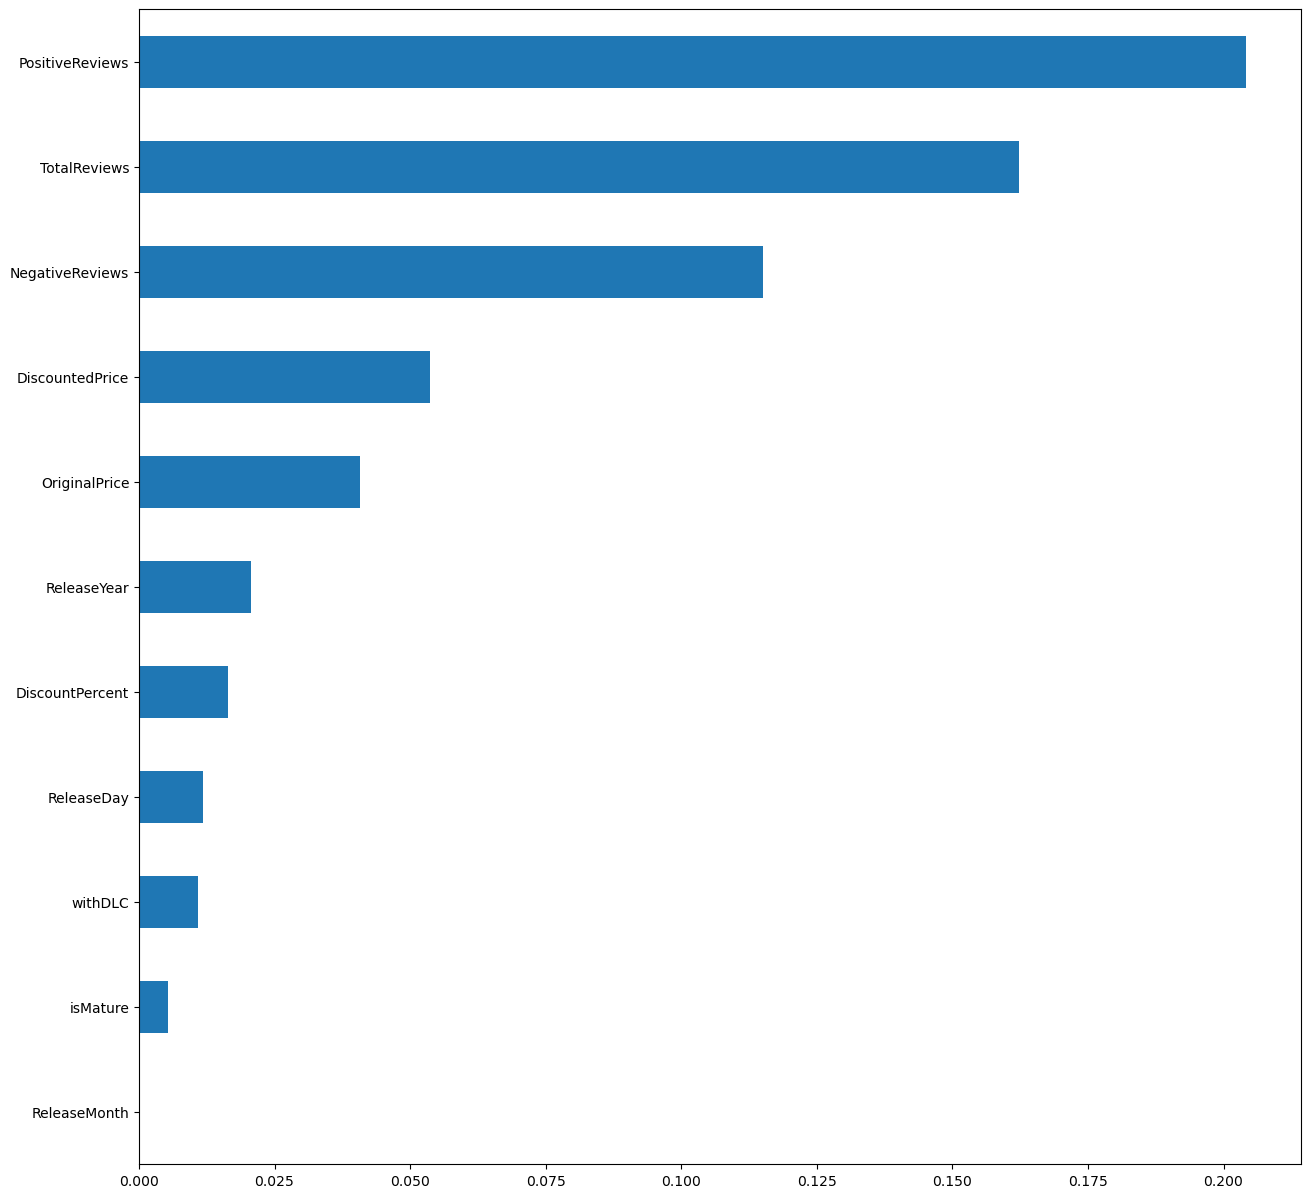

In [12]:
X = cleaned_df.drop(columns = 'Rating')
y = cleaned_df['Rating']
numeric_X = X.select_dtypes(include='number')
mi_scores = mutual_info_regression(numeric_X, y)
mi_scores = pd.Series(mi_scores, index = numeric_X.columns).sort_values(ascending = True)

plt.figure(figsize = (15, 15))
mi_scores.plot.barh()
plt.show()

## Pipeline cho bước tiền xử lí
Đầu tiên, ta sẽ tìm những cột dữ liệu không là kiểu dữ liệu số:

In [13]:
cat_df = cleaned_df.select_dtypes(include='object')
cat_df

,Genre,Developer,Publisher,Languages
0,"Action, Adventure, RPG, Early Access",Yodubzz Studios,Freedom Games,"English, French, German, Spanish - Spain, Japa..."
1,"Adventure, Casual, Indie, Simulation, Strategy...",Cassel Games,Cassel Games,"English, Korean, Japanese, Simplified Chinese,..."
2,"Action, Adventure, Early Access",Hutlihut Games,Focus Entertainment,"English, French, German, Spanish - Spain, Poli..."
3,"Action, Adventure, Casual, Indie",SandCastles Studio,Apogee Entertainment,"English, Spanish - Spain, Catalan, French, Ita..."
4,"Simulation, Early Access",Sparkypants,Klei Publishing,"English, Simplified Chinese"
...,...,...,...,...
5966,"Adventure, Casual, Indie, Simulation",Dirty Fox Games,Dirty Fox Games,English
5967,"Adventure, Casual, Indie",Suits & Sandals,Suits & Sandals,"English, Japanese"
5968,Action,Raven Software,id Software,English
5969,Action,[2.21],[2.21],English


Do `Genre` là cột mà mỗi sample có thể có một hoặc nhiều thể loại, do đó phương pháp encoding phù hợp nhất hiện tại là `One Hot Encoding`.
Ta có 2 cột `Developer` và `Publisher` là 2 cột không phải là dữ liệu số, ta sẽ tiến hành encode 2 cột này bằng `TargetEncoder`. Lí do không sử dụng One hot encoding do lo ngại việc quá nhiều cột ảnh hưởng đến hiệu năng của mô hình.

Ta scale các cột dữ liệu số cho model (Những cột có tiền tố `Genre` sẽ không được đưa vào vì nó là những cột `category` được encode, không phải là dữ liệu số thuần túy).

In [14]:
numeric_df = X.select_dtypes(include='number')
numeric_df

,withDLC,isMature,PositiveReviews,TotalReviews,NegativeReviews,OriginalPrice,DiscountPercent,DiscountedPrice,ReleaseYear,ReleaseMonth,ReleaseDay
0,0.0,0.0,1581.0,2081.0,500.0,260000.0,0.20,208000.0,2023,9,18
1,1.0,0.0,1602.0,1807.0,205.0,260000.0,0.10,234000.0,2023,11,5
2,0.0,0.0,2071.0,2280.0,209.0,286000.0,0.20,228800.0,2023,9,7
3,1.0,0.0,2332.0,2644.0,312.0,205000.0,0.25,153750.0,2023,5,23
4,0.0,0.0,583.0,632.0,49.0,220000.0,0.10,198000.0,2023,12,14
...,...,...,...,...,...,...,...,...,...,...,...
5966,1.0,1.0,18.0,18.0,0.0,73500.0,0.00,73500.0,2023,12,2
5967,1.0,0.0,184.0,190.0,6.0,73500.0,0.90,7350.0,2020,11,29
5968,0.0,0.0,372.0,453.0,81.0,112500.0,0.70,33750.0,1998,3,27
5969,0.0,0.0,57.0,61.0,4.0,87500.0,0.00,87500.0,1996,7,31


In [15]:
# Lấy những cột categorical và numerical
cat_cols = cat_df.columns
numeric_cols = numeric_df.columns
        
# Pipeline xử lý cho các cột category
target_encode_transformer = Pipeline(steps= [('TargetEncoder', TargetEncoder())])
onehot_encode_transformer = Pipeline( steps=[
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))])

# Pipeline xử lý cho các cột numeric
numeric_transfomer = Pipeline(steps= [('scaler', MinMaxScaler())])  # scale các giá trị về miền giá trị trong khoảng 0 đến 1 


# Pipeline cho quá trình tiền xử lí
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_transformer', onehot_encode_transformer, [cat_cols[0], cat_cols[3]]), # Sử dụng One Hot Encoding cho cột Genre
        ('target_transformer', target_encode_transformer, list(cat_cols[1:])), # Sử dụng Target Encoding cho Publisher và Developer
        ('numeric_transfomer', numeric_transfomer, list(numeric_cols)),
    ],
    remainder='passthrough'  # keep the non-transformed columns
)

#### Validation

In [16]:
def Cross_val_scores(model, X_val, y_val):
    scores = -1 * cross_val_score(model, X_val, y_val, cv = 5, scoring = 'neg_mean_squared_error', error_score='raise')
    
    return np.sqrt(scores).mean()

In [17]:
models = [('Linear Regression', LinearRegression()), 
          ('Decision Tree', DecisionTreeRegressor()),
          ('Random Forest', RandomForestRegressor()),
          ('Gradient Boosting', GradientBoostingRegressor())]

##### Features chứa Release Date

In [18]:
X = cleaned_df.drop('Rating', axis = 1)
y = cleaned_df['Rating']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train

,Genre,withDLC,isMature,Developer,Publisher,Languages,PositiveReviews,TotalReviews,NegativeReviews,OriginalPrice,DiscountPercent,DiscountedPrice,ReleaseYear,ReleaseMonth,ReleaseDay
2410,"Casual, Indie, Simulation",0.0,0.0,SECRET CHARACTER,SECRET CHARACTER,"English, Japanese, Simplified Chinese, Traditi...",321.0,343.0,22.0,70000.0,0.00,70000.0,2022,6,3
1173,"Action, Adventure, Indie",1.0,0.0,Krome Studios,Krome Studios,"English, French, German, Italian, Spanish - Sp...",650.0,680.0,30.0,165000.0,0.65,57750.0,2017,12,12
5414,"Action, Casual, Indie, Strategy, Early Access",0.0,0.0,Kraken Empire,Joystick Ventures,"English, Spanish - Spain, Simplified Chinese",49.0,52.0,3.0,260000.0,0.25,195000.0,2023,3,17
1670,Action,0.0,0.0,Red Storm Entertainment,Ubisoft,English,1584.0,1725.0,141.0,83000.0,0.75,20750.0,2003,3,18
944,"Action, Adventure",0.0,0.0,Ubisoft Montreal,Ubisoft,"English, French, German, Italian, Spanish - Spain",1387.0,1759.0,372.0,165000.0,0.80,33000.0,2005,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,"Casual, Indie, Simulation, Strategy",1.0,0.0,Team L.U.R.Id Glow,Team L.U.R.Id Glow,"English, Japanese, Simplified Chinese",1245.0,1471.0,226.0,185000.0,0.25,138750.0,2019,11,11
5191,"Action, Indie, Early Access",0.0,0.0,The Spiteful Games,The Spiteful Games,"English, Korean, Japanese, Russian",81.0,119.0,38.0,188000.0,0.30,131600.0,2020,3,11
5226,"Action, Adventure, Indie",1.0,1.0,Paul Helman,505 Games,"English, French, Italian, German, Spanish - Spain",498.0,621.0,123.0,165000.0,0.70,49500.0,2019,7,18
5390,Simulation,1.0,0.0,N3V Games,N3V Games,English,1311.0,1796.0,485.0,120000.0,0.55,54000.0,2011,6,8


In [20]:
performances = {} # dict used to store cross_val_scores of each model to examine

for name, model in models:
    multi_model_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('regression', model)]
    )
    try:
        scores = Cross_val_scores(multi_model_pl, X_train, y_train)
        print(f"{name} cross-validated score:", scores)
        performances[name] = scores
    except ValueError as e:
        print("Error during cross-validation:", e)

Linear Regression cross-validated score: 0.059072359968817066
Decision Tree cross-validated score: 0.012578227699201394
Random Forest cross-validated score: 0.0067031924959243695
Gradient Boosting cross-validated score: 0.008375700468444481


In [21]:
performances

{'Linear Regression': 0.059072359968817066,
 'Decision Tree': 0.012578227699201394,
 'Random Forest': 0.0067031924959243695,
 'Gradient Boosting': 0.008375700468444481}

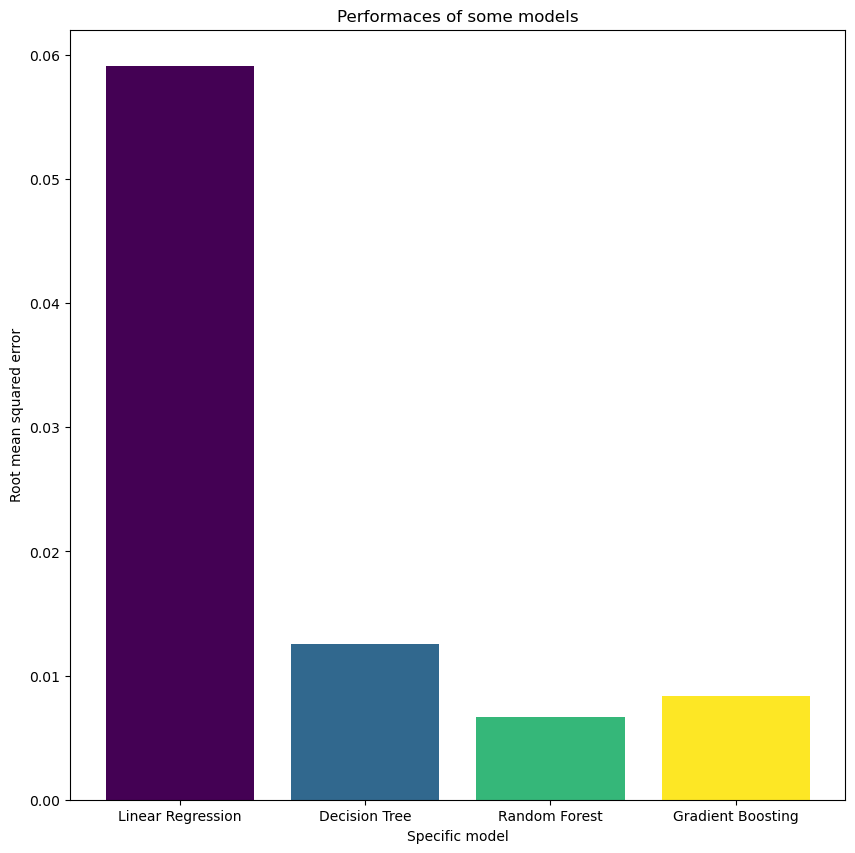

In [22]:
plt.figure(figsize = (10, 10))
colors = cm.viridis(np.linspace(0, 1, len(performances)))
plt.bar(performances.keys(), performances.values(), color = colors)
plt.xlabel('Specific model')
plt.ylabel('Root mean squared error')
plt.title('Performaces of some models')
plt.show()

#### => Vậy ta chọn được mô hình cho kết quả tốt nhất là Random Forest

##### TEST model on test set

In [23]:
rf_pl = Pipeline(
    steps=[("preprocessor", preprocessor), ('RandomForestRegression', RandomForestRegressor())])

rf_pl.fit(X_train, y_train)
y_train_pred = rf_pl.predict(X_train)

In [24]:
y_test_pred = rf_pl.predict(X_test)
print(f'Train set: MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'Test set: MSE: {mean_squared_error(y_test, y_test_pred)}')

Train set: MSE: 7.72087723640196e-06
Test set: MSE: 3.540279833811614e-05


# 3. Fine tuning

Chúng ta đã xây dựng một mô hình **Random Forest** để giải quyết vấn đề Machine Learning nhưng không quá ấn tượng với kết quả. Lựa chọn của chúng ta là gì? Bước đầu tiên của chúng ta là thu thập thêm dữ liệu và thực hiện **feature engineering**. Việc thu thập thêm dữ liệu và feature engineering thường mang lại lợi ích lớn nhất về mặt thời gian đầu tư so với hiệu suất được cải thiện, nhưng khi chúng ta đã sử dụng hết tất cả các nguồn dữ liệu, đã đến lúc chuyển sang điều chỉnh siêu tham số mô hình `Hyperparameter Tuning`. 

Xem xét qua các hyperparameter mặc định khi sử dụng mô hình `Random Forest` ở trên:

In [25]:
rf_pl.named_steps['RandomForestRegression'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Chúng tôi sẽ điều chỉnh bộ hyperparameter sau:

- **n_estimators** = số lượng cây trong rừng
- **max_features** = số lượng feature tối đa được xem xét để tách một node
- **max_deep** = số cấp tối đa trong mỗi cây quyết định
- **min_samples_split** = số lượng điểm dữ liệu tối thiểu được đặt trong một node trước khi node được chia
- **min_samples_leaf** = số điểm dữ liệu tối thiểu được phép trong node lá
- **bootstrap** = phương pháp lấy mẫu điểm dữ liệu (có hoặc không thay thế)

## 3.1 Hyperparameter Grid
Trước tiên ta tạo một parameter grid để lấy mẫu trong khi thực hiện fit.

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [2, 4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'RandomForestRegression__n_estimators': n_estimators,
    'RandomForestRegression__max_features': max_features,
    'RandomForestRegression__max_depth': max_depth,
    'RandomForestRegression__min_samples_split': min_samples_split,
    'RandomForestRegression__min_samples_leaf': min_samples_leaf,
    'RandomForestRegression__bootstrap': bootstrap
}
random_grid

{'RandomForestRegression__n_estimators': [10,
  17,
  25,
  33,
  41,
  48,
  56,
  64,
  72,
  80],
 'RandomForestRegression__max_features': ['sqrt', 'log2'],
 'RandomForestRegression__max_depth': [2, 4],
 'RandomForestRegression__min_samples_split': [2, 5],
 'RandomForestRegression__min_samples_leaf': [1, 2],
 'RandomForestRegression__bootstrap': [True, False]}

#### Tạo model dựa vào Pipeline được định nghĩa ở trên, với model đang xét là Random Forest

In [27]:
rf_Model = Pipeline(
    steps=[("preprocessor", preprocessor), ('RandomForestRegression', RandomForestRegressor())])
rf_Model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_transformer',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Genre', 'Languages']),
                                                 ('target_transformer',
                                                  Pipeline(steps=[('TargetEncoder',
                                                                   TargetEncoder())]),
                                                  ['Developer', 'Publisher',
                                                   'Languages']),
                                                 ('numeric_transfomer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['withDLC', 'isMature',
                                                   'PositiveReviews',
                                                   'TotalReviews',
                                                   'NegativeReviews',
                                                   'OriginalPrice',
                                                   'DiscountPercent',
                                                   'DiscountedPrice',
                                                   'ReleaseYear',
                                                   'ReleaseMonth',
                                                   'ReleaseDay'])])),
                ('RandomForestRegression', RandomForestRegressor())])

#### GridSearchCV

In [28]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = random_grid, cv = 10, verbose=1, n_jobs = -1, error_score='raise')

# Fit the random search model
rf_Grid.fit(X_train, y_train)

rf_Grid.best_params_

Fitting 10 folds for each of 320 candidates, totalling 3200 fits


{'RandomForestRegression__bootstrap': False,
 'RandomForestRegression__max_depth': 4,
 'RandomForestRegression__max_features': 'sqrt',
 'RandomForestRegression__min_samples_leaf': 2,
 'RandomForestRegression__min_samples_split': 2,
 'RandomForestRegression__n_estimators': 17}

In [29]:
rf_Grid.best_score_

0.07509314988963789

In [30]:
print(f'Train Accuracy: {rf_Grid.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {rf_Grid.score(X_test, y_test):.3f}')

Train Accuracy: 0.115
Test Accuracy: 0.067


#### Evaluate Model tốt nhất từ Grid Search

Đầu tiên ta define hàm evaluate

In [31]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [32]:
best_grid = rf_Grid.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
Average Error: 0.0640 degrees.
Accuracy = 91.38%.


In [33]:
pickle.dump(best_grid, open('model.pkl', 'wb'))